In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources (run once)
# nltk.download('punkt', quiet=True)
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [27]:
# Configuration parameters
MAX_WORDS = 2000
MAX_SEQUENCE_LENGTH = 60
EMBEDDING_DIM = 100

print(f"Parameters set:")
print(f"Max words: {MAX_WORDS}")
print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Parameters set:
Max words: 2000
Max sequence length: 60
Embedding dimension: 100


In [28]:
# File paths
TRAIN_PATH = "train.tsv"
VAL_PATH = "valid.tsv"
TEST_PATH = "test.tsv"
GLOVE_PATH = "glove.6B.100d.txt"

# Load the dataset from TSV files
print("Loading data...")
train_df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)
val_df = pd.read_csv(VAL_PATH, sep='\t', header=None)
test_df = pd.read_csv(TEST_PATH, sep='\t', header=None)

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Loading data...


Train shape: (10240, 14)
Validation shape: (1284, 14)
Test shape: (1267, 14)


In [29]:
def replace_labels(label):
    """Convert multi-class labels to binary classification"""
    label = label.lower().replace(" ", "-")
    return "true" if label in ["true", "mostly-true"] else "false"

In [30]:
# Apply label transformation to all dataframes
print("Applying label transformation...")
train_df[1] = train_df[1].apply(replace_labels)
val_df[1] = val_df[1].apply(replace_labels)
test_df[1] = test_df[1].apply(replace_labels)

# Print class distribution
print("Train Set Label Distribution:")
print(train_df[1].value_counts())
print(f"Train set total: {len(train_df)}")

print("\nValidation Set Label Distribution:")
print(val_df[1].value_counts())
print(f"Validation set total: {len(val_df)}")

print("\nTest Set Label Distribution:")
print(test_df[1].value_counts())
print(f"Test set total: {len(test_df)}")

Applying label transformation...
Train Set Label Distribution:
1
false    6602
true     3638
Name: count, dtype: int64
Train set total: 10240

Validation Set Label Distribution:
1
false    864
true     420
Name: count, dtype: int64
Validation set total: 1284

Test Set Label Distribution:
1
false    818
true     449
Name: count, dtype: int64
Test set total: 1267


In [31]:
def combine_text(df):
    """Concatenate statement with relevant metadata fields"""
    df = df.fillna('')
    combined = (
        df[2].astype(str) + " " +  # statement
        df[3].astype(str) + " " +  # subject(s)
        df[4].astype(str) + " " +  # speaker
        df[5].astype(str) + " " +  # speaker's job title
        df[6].astype(str) + " " +  # state info
        df[7].astype(str) + " " +  # party affiliation
        df[13].astype(str)         # context (venue/location)
    )
    return combined.tolist()

In [32]:
def preprocess_text(text):
    """Preprocess individual text"""
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [33]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Admin\AppData\Roaming\nltk_data...
[

True

In [34]:
# Create combined text inputs for all datasets
print("Creating combined text inputs...")
train_statements = combine_text(train_df)
val_statements = combine_text(val_df)
test_statements = combine_text(test_df)

print(f"Combined {len(train_statements)} training statements")
print(f"Combined {len(val_statements)} validation statements")
print(f"Combined {len(test_statements)} test statements")

# Apply preprocessing to all statements
print("Preprocessing text...")
train_statements_processed = [preprocess_text(statement) for statement in tqdm(train_statements, desc="Training Statements")]
val_statements_processed = [preprocess_text(statement) for statement in tqdm(val_statements, desc="Validation Statements")]
test_statements_processed = [preprocess_text(statement) for statement in tqdm(test_statements, desc="Test Statements")]

Creating combined text inputs...
Combined 10240 training statements
Combined 1284 validation statements
Combined 1267 test statements
Preprocessing text...


Test Statements: 100%|██████████| 1267/1267 [00:03<00:00, 398.54it/s]


In [35]:
def map_labels(label_list):
    """Map string labels to integers"""
    label_map = {"false": 0, "true": 1}
    mapped = []
    for label in label_list:
        label = label.lower().replace(" ", "-")
        mapped.append(label_map.get(label, 0))
    return np.array(mapped)

# Prepare labels
print("Preparing labels...")
train_labels = map_labels(train_df[1].tolist())
val_labels = map_labels(val_df[1].tolist())
test_labels = map_labels(test_df[1].tolist())

# Show label distribution
print(f"\nTrain label distribution: {np.bincount(train_labels)}")
print(f"Validation label distribution: {np.bincount(val_labels)}")
print(f"Test label distribution: {np.bincount(test_labels)}")

Preparing labels...

Train label distribution: [6602 3638]
Validation label distribution: [864 420]
Test label distribution: [818 449]


In [36]:
# Initialize tokenizer
print("Setting up tokenizer...")
tokenizer = Tokenizer(num_words=MAX_WORDS)

# Fit tokenizer on all preprocessed statements
all_statements = train_statements_processed + val_statements_processed + test_statements_processed
tokenizer.fit_on_texts(all_statements)

print(f"Tokenizer vocabulary size: {len(tokenizer.word_index)}")
print(f"Max words used: {MAX_WORDS}")

Setting up tokenizer...
Tokenizer vocabulary size: 14785
Max words used: 2000


Converting statements to sequences...


Training Sequences:   0%|          | 0/10240 [00:00<?, ?it/s]

Test Sequences: 100%|██████████| 1267/1267 [00:00<00:00, 40064.11it/s]


Sequence conversion completed!

Sequence length statistics:
  Mean length: 20.54
  Max length: 374
  Min length: 4
  95th percentile: 30.00


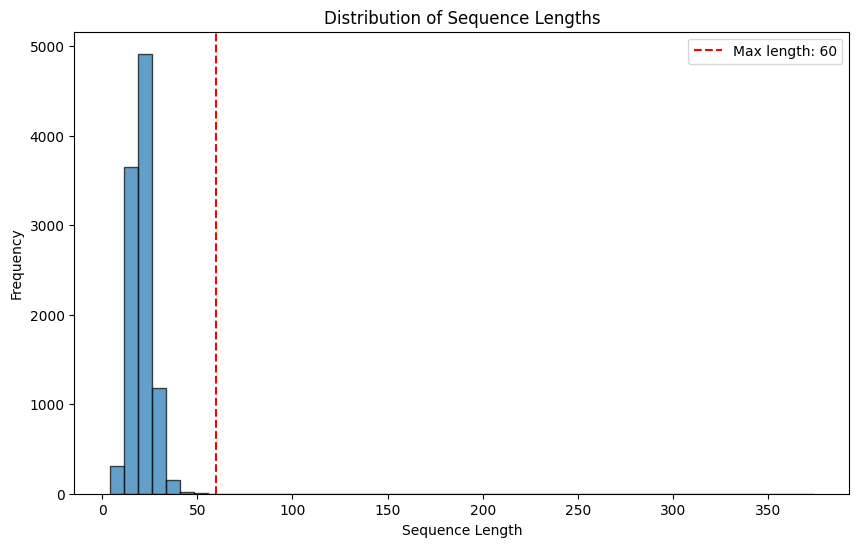

In [37]:
# Convert statements to sequences
print("Converting statements to sequences...")
train_sequences = [tokenizer.texts_to_sequences([text])[0] for text in tqdm(train_statements_processed, desc="Training Sequences")]
val_sequences = [tokenizer.texts_to_sequences([text])[0] for text in tqdm(val_statements_processed, desc="Validation Sequences")]
test_sequences = [tokenizer.texts_to_sequences([text])[0] for text in tqdm(test_statements_processed, desc="Test Sequences")]

print("Sequence conversion completed!")

# Show sequence statistics
train_lengths = [len(seq) for seq in train_sequences]
print(f"\nSequence length statistics:")
print(f"  Mean length: {np.mean(train_lengths):.2f}")
print(f"  Max length: {np.max(train_lengths)}")
print(f"  Min length: {np.min(train_lengths)}")
print(f"  95th percentile: {np.percentile(train_lengths, 95):.2f}")

# Plot sequence length distribution
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(MAX_SEQUENCE_LENGTH, color='red', linestyle='--', label=f'Max length: {MAX_SEQUENCE_LENGTH}')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend()
plt.show()

In [38]:
# Pad sequences to the same length
print("Padding sequences...")
train_data_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
val_data_padded = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
test_data_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

print(f"Padded data shapes:")
print(f"  Training: {train_data_padded.shape}")
print(f"  Validation: {val_data_padded.shape}")
print(f"  Test: {test_data_padded.shape}")

# Show sample padded sequence
print(f"\nSample padded sequence (first 20 elements):")
print(train_data_padded[0][:20])

Padding sequences...
Padded data shapes:
  Training: (10240, 60)
  Validation: (1284, 60)
  Test: (1267, 60)

Sample padded sequence (first 20 elements):
[   4  895  211  249  206  457  100 1956  100    2   34   15    1  376
    0    0    0    0    0    0]


In [39]:
# Load GloVe embeddings
print("Loading GloVe embeddings...")
embeddings_index = {}

try:
    with open(GLOVE_PATH, encoding='utf8') as f:
        # Count total lines for progress bar
        total_lines = sum(1 for _ in open(GLOVE_PATH, encoding='utf8'))
        print(f"Total GloVe vectors: {total_lines}")
        
        # Read embeddings
        for line in tqdm(f, total=total_lines, desc="Reading GloVe File"):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print(f"Loaded {len(embeddings_index)} word vectors")
    
except FileNotFoundError:
    print(f"GloVe file not found at {GLOVE_PATH}")
    print("You can download it from: https://nlp.stanford.edu/projects/glove/")
    # Create random embeddings as fallback
    print("Creating random embeddings as fallback...")
    embeddings_index = {}

Loading GloVe embeddings...
Total GloVe vectors: 400000


Reading GloVe File: 100%|██████████| 400000/400000 [00:22<00:00, 17475.94it/s]

Loaded 400000 word vectors


In [40]:
# Create embedding matrix
print("Creating embedding matrix...")
word_index = tokenizer.word_index
num_words = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Fill embedding matrix
words_found = 0
words_not_found = 0

for word, i in word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            words_found += 1
        else:
            words_not_found += 1

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Words found in GloVe: {words_found}")
print(f"Words not found in GloVe: {words_not_found}")
print(f"Coverage: {words_found / (words_found + words_not_found) * 100:.2f}%")

Creating embedding matrix...
Embedding matrix shape: (2000, 100)
Words found in GloVe: 1991
Words not found in GloVe: 8
Coverage: 99.60%


=== DATA PROCESSING SUMMARY ===
Training samples: 10240
Validation samples: 1284
Test samples: 1267
Vocabulary size: 2000
Sequence length: 60
Embedding dimension: 100


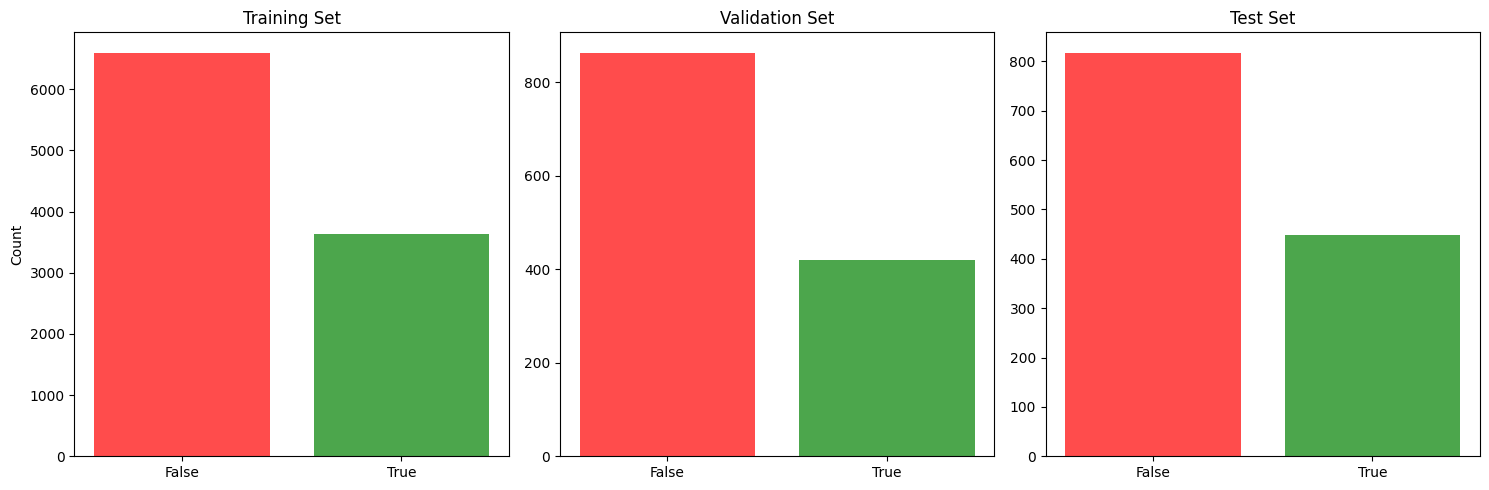

Train set - False: 64.5%, True: 35.5%
Val set - False: 67.3%, True: 32.7%
Test set - False: 64.6%, True: 35.4%


In [41]:
# Create summary of processed data
print("=== DATA PROCESSING SUMMARY ===")
print(f"Training samples: {len(train_data_padded)}")
print(f"Validation samples: {len(val_data_padded)}")
print(f"Test samples: {len(test_data_padded)}")
print(f"Vocabulary size: {num_words}")
print(f"Sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Embedding dimension: {EMBEDDING_DIM}")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Training set
train_counts = np.bincount(train_labels)
axes[0].bar(['False', 'True'], train_counts, color=['red', 'green'], alpha=0.7)
axes[0].set_title('Training Set')
axes[0].set_ylabel('Count')

# Validation set
val_counts = np.bincount(val_labels)
axes[1].bar(['False', 'True'], val_counts, color=['red', 'green'], alpha=0.7)
axes[1].set_title('Validation Set')

# Test set
test_counts = np.bincount(test_labels)
axes[2].bar(['False', 'True'], test_counts, color=['red', 'green'], alpha=0.7)
axes[2].set_title('Test Set')

plt.tight_layout()
plt.show()

# Print class balance
for name, labels in [('Train', train_labels), ('Val', val_labels), ('Test', test_labels)]:
    false_pct = (labels == 0).mean() * 100
    true_pct = (labels == 1).mean() * 100
    print(f"{name} set - False: {false_pct:.1f}%, True: {true_pct:.1f}%")

In [42]:
# Save all preprocessed data and objects
print("Saving preprocessed data...")

# Create data dictionary
preprocessed_data = {
    'train_data': train_data_padded,
    'val_data': val_data_padded,
    'test_data': test_data_padded,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels,
    'embedding_matrix': embedding_matrix,
    'num_words': num_words,
    'embedding_dim': EMBEDDING_DIM,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'tokenizer': tokenizer
}

# Save to pickle file
with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("Preprocessed data saved to 'preprocessed_data.pkl'")
print("✅ Data preprocessing completed successfully!")
print("You can now use this data to train your LSTM model.")

Saving preprocessed data...
Preprocessed data saved to 'preprocessed_data.pkl'
✅ Data preprocessing completed successfully!
You can now use this data to train your LSTM model.


In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
# Cell 19: TextCNN Model Configuration Parameters
print("=== TEXTCNN MODEL CONFIGURATION ===")

# Model architecture parameters
FILTER_SIZES = [3, 4, 5]  # Different filter sizes for convolution
NUM_FILTERS = 128         # Number of filters per filter size
DENSE_UNITS_1 = 100      # First dense layer units
DENSE_UNITS_2 = 50       # Second dense layer units
DROPOUT_RATE = 0.5       # Dropout rate

# Training parameters
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

print(f"Filter sizes: {FILTER_SIZES}")
print(f"Number of filters per size: {NUM_FILTERS}")
print(f"Dense layer 1 units: {DENSE_UNITS_1}")
print(f"Dense layer 2 units: {DENSE_UNITS_2}")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")

=== TEXTCNN MODEL CONFIGURATION ===
Filter sizes: [3, 4, 5]
Number of filters per size: 128
Dense layer 1 units: 100
Dense layer 2 units: 50
Dropout rate: 0.5
Epochs: 10
Batch size: 128
Learning rate: 0.001


In [45]:
# Cell 20: Build TextCNN Model Architecture
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPool1D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print("Building TextCNN model...")

# Input layer
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_layer')

# Embedding layer (using pre-trained GloVe embeddings)
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,  # Freeze pre-trained embeddings
    name='embedding_layer'
)(input_layer)

# Multiple convolutional layers with different filter sizes
conv_blocks = []
for i, filter_size in enumerate(FILTER_SIZES):
    conv = Conv1D(
        filters=NUM_FILTERS,
        kernel_size=filter_size,
        activation='relu',
        name=f'conv1d_{filter_size}'
    )(embedding_layer)
    
    # Global max pooling
    pooled = GlobalMaxPool1D(name=f'global_max_pool_{filter_size}')(conv)
    conv_blocks.append(pooled)

# Concatenate all pooled outputs
if len(conv_blocks) > 1:
    concatenated = Concatenate(name='concatenate')(conv_blocks)
else:
    concatenated = conv_blocks[0]

# First dropout layer
dropout1 = Dropout(DROPOUT_RATE, name='dropout_1')(concatenated)

# First dense layer
dense1 = Dense(DENSE_UNITS_1, activation='relu', name='dense_1')(dropout1)

# Second dropout layer
dropout2 = Dropout(DROPOUT_RATE, name='dropout_2')(dense1)

# Second dense layer
dense2 = Dense(DENSE_UNITS_2, activation='relu', name='dense_2')(dropout2)

# Output layer
output_layer = Dense(1, activation='sigmoid', name='output_layer')(dense2)

# Create model
textcnn_model = Model(inputs=input_layer, outputs=output_layer, name='TextCNN')

# Compile model
optimizer = Adam(learning_rate=LEARNING_RATE)
textcnn_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Display model summary
print("\n=== MODEL ARCHITECTURE ===")
textcnn_model.summary()

Building TextCNN model...


e:\EPITA\Action_Learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



=== MODEL ARCHITECTURE ===


Model: "TextCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 60, 100)   │    200,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 58, 128)   │     38,528 │ embedding_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 57, 128)   │     51,328 │ embedding_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 56, 128)   │     64,128 │ embedding_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool_3   │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool_4   │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool_5   │ (None, 128)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pool_… │
│ (Concatenate)       │                   │            │ global_max_pool_… │
│                     │                   │            │ global_max_pool_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     38,500 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 50)        │      5,050 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │         51 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 397,585 (1.52 MB)

 Trainable params: 197,585 (771.82 KB)

 Non-trainable params: 200,000 (781.25 KB)

In [46]:
# Cell 21: Calculate Class Weights and Training Setup
print("=== CLASS WEIGHTS ===")
CLASS_WEIGHT_DICT = {0: 1.0, 1: 1.6}
print(f"Class distribution in training set:")
print(f"False (0): {np.sum(train_labels == 0)} samples")
print(f"True (1): {np.sum(train_labels == 1)} samples")
print(f"Class weights: {CLASS_WEIGHT_DICT}")

# Define callbacks (keep as is, but ensure consistency in training)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001,
    verbose=1
)
callbacks = [early_stopping, reduce_lr]

print(f"\nCallbacks configured:")
print(f"- Early stopping (patience: 3)")
print(f"- Learning rate reduction (factor: 0.2, patience: 2)")

=== CLASS WEIGHTS ===
Class distribution in training set:
False (0): 6602 samples
True (1): 3638 samples
Class weights: {0: 1.0, 1: 1.6}

Callbacks configured:
- Early stopping (patience: 3)
- Learning rate reduction (factor: 0.2, patience: 2)


In [47]:
# Cell 22: Train the TextCNN Model
print("=== TRAINING TEXTCNN MODEL ===")
print(f"Training samples: {len(train_data_padded)}")
print(f"Validation samples: {len(val_data_padded)}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")

# Train the model
textcnn_history = textcnn_model.fit(
    train_data_padded, train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_data_padded, val_labels),
    class_weight=CLASS_WEIGHT_DICT,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

=== TRAINING TEXTCNN MODEL ===


Training samples: 10240
Validation samples: 1284
Epochs: 10
Batch size: 128
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 153ms/step - accuracy: 0.5426 - auc: 0.5032 - loss: 0.9698 - precision: 0.3628 - recall: 0.3946 - val_accuracy: 0.3333 - val_auc: 0.4719 - val_loss: 0.7161 - val_precision: 0.3289 - val_recall: 0.9976 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.5703 - auc: 0.5206 - loss: 0.8442 - precision: 0.3783 - recall: 0.3205 - val_accuracy: 0.6347 - val_auc: 0.5810 - val_loss: 0.6817 - val_precision: 0.4000 - val_recall: 0.2333 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.5865 - auc: 0.5510 - loss: 0.8338 - precision: 0.3984 - recall: 0.3333 - val_accuracy: 0.5413 - val_auc: 0.6241 - val_loss: 0.6802 - val_precision: 0.3838 - val_recall: 0.6643 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.5837 - auc: 0.5777 - loss: 0.8275 - precision: 0.4211 -

In [48]:
# Evaluate the TextCNN model on test set
print("Evaluating TextCNN model on test set...")
textcnn_test_metrics = textcnn_model.evaluate(test_data_padded, test_labels, return_dict=True)

# Print all metrics
print(f"\n=== FINAL TextCNN TEST RESULTS ===")
print(f"TextCNN Test Accuracy: {textcnn_test_metrics['accuracy']:.4f}")
print(f"TextCNN Test Precision: {textcnn_test_metrics['precision']:.4f}")
print(f"TextCNN Test Recall: {textcnn_test_metrics['recall']:.4f}")
print(f"TextCNN Test AUC: {textcnn_test_metrics['auc']:.4f}")

# Calculate F1 score
textcnn_precision = textcnn_test_metrics['precision']
textcnn_recall = textcnn_test_metrics['recall']
textcnn_f1_score = 2 * (textcnn_precision * textcnn_recall) / (textcnn_precision + textcnn_recall)
print(f"TextCNN Test F1 Score: {textcnn_f1_score:.4f}")

Evaluating TextCNN model on test set...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6437 - auc: 0.6697 - loss: 0.6344 - precision: 0.4899 - recall: 0.4985

=== FINAL TextCNN TEST RESULTS ===
TextCNN Test Accuracy: 0.6393
TextCNN Test Precision: 0.4916
TextCNN Test Recall: 0.5234
TextCNN Test AUC: 0.6627
TextCNN Test F1 Score: 0.5070


In [49]:
# Make predictions on test data
print("Making predictions with TextCNN model...")
textcnn_y_pred = textcnn_model.predict(test_data_padded, batch_size=BATCH_SIZE, verbose=0)

# Convert predictions to binary classes
textcnn_y_pred_classes = (textcnn_y_pred > 0.5).astype(int).flatten()
textcnn_y_true_classes = test_labels

print(f"TextCNN Predictions shape: {textcnn_y_pred.shape}")
print(f"TextCNN Binary predictions shape: {textcnn_y_pred_classes.shape}")
print(f"TextCNN True labels shape: {textcnn_y_true_classes.shape}")

# Show sample predictions
print(f"\nSample TextCNN predictions (first 10):")
for i in range(10):
    prob = textcnn_y_pred[i][0]
    pred_class = textcnn_y_pred_classes[i]
    true_class = textcnn_y_true_classes[i]
    correct = "✓" if pred_class == true_class else "✗"
    print(f"Sample {i+1}: Prob={prob:.3f}, Pred={pred_class}, True={true_class} {correct}")

Making predictions with TextCNN model...
TextCNN Predictions shape: (1267, 1)
TextCNN Binary predictions shape: (1267,)
TextCNN True labels shape: (1267,)

Sample TextCNN predictions (first 10):
Sample 1: Prob=0.398, Pred=0, True=1 ✗
Sample 2: Prob=0.595, Pred=1, True=0 ✗
Sample 3: Prob=0.209, Pred=0, True=0 ✓
Sample 4: Prob=0.222, Pred=0, True=0 ✓
Sample 5: Prob=0.332, Pred=0, True=0 ✓
Sample 6: Prob=0.405, Pred=0, True=1 ✗
Sample 7: Prob=0.498, Pred=0, True=1 ✗
Sample 8: Prob=0.358, Pred=0, True=0 ✓
Sample 9: Prob=0.463, Pred=0, True=1 ✗
Sample 10: Prob=0.324, Pred=0, True=0 ✓


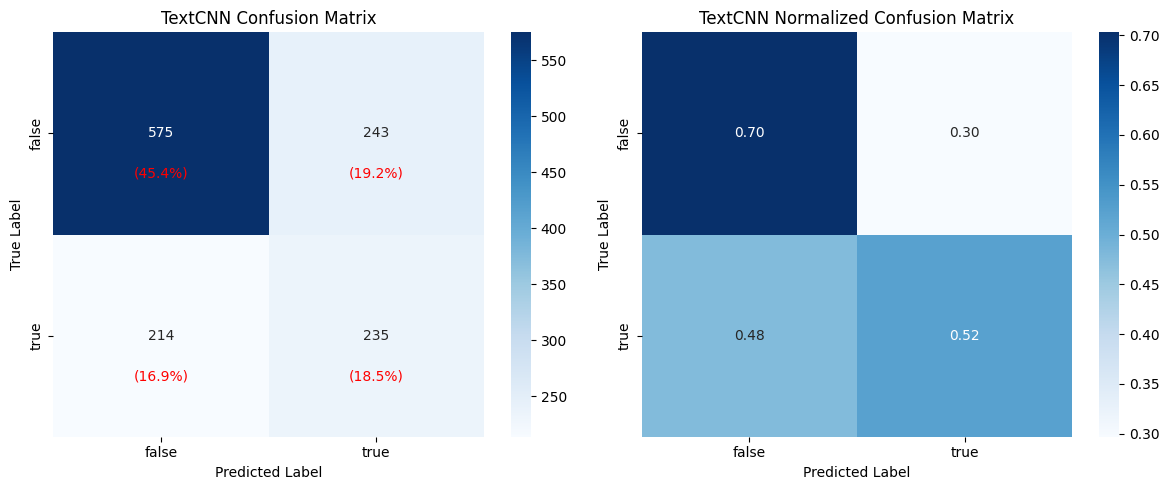

TextCNN Confusion Matrix Statistics:
True Negatives: 575
False Positives: 243
False Negatives: 214
True Positives: 235


In [50]:
# Create and plot confusion matrix for TextCNN
textcnn_class_names = ['false', 'true']
textcnn_cm = confusion_matrix(textcnn_y_true_classes, textcnn_y_pred_classes)

# Create figure with subplots
plt.figure(figsize=(12, 5))

# Regular confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(textcnn_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=textcnn_class_names, yticklabels=textcnn_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TextCNN Confusion Matrix')

# Add text annotations with percentages
textcnn_total = textcnn_cm.sum()
for i in range(len(textcnn_class_names)):
    for j in range(len(textcnn_class_names)):
        plt.text(j+0.5, i+0.7, f'({textcnn_cm[i,j]/textcnn_total*100:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

# Normalized confusion matrix
textcnn_cm_normalized = textcnn_cm.astype('float') / textcnn_cm.sum(axis=1)[:, np.newaxis]
plt.subplot(1, 2, 2)
sns.heatmap(textcnn_cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
           xticklabels=textcnn_class_names, yticklabels=textcnn_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TextCNN Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Print confusion matrix statistics
print("TextCNN Confusion Matrix Statistics:")
print(f"True Negatives: {textcnn_cm[0,0]}")
print(f"False Positives: {textcnn_cm[0,1]}")
print(f"False Negatives: {textcnn_cm[1,0]}")
print(f"True Positives: {textcnn_cm[1,1]}")

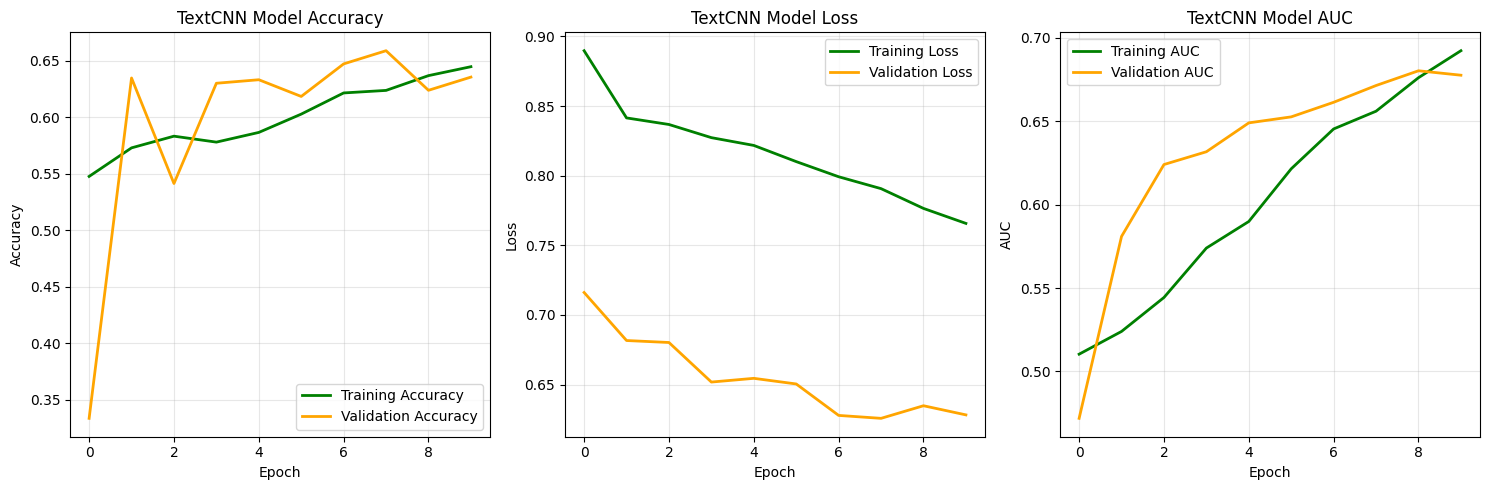


TextCNN Best epoch: 8
TextCNN Best validation accuracy: 0.6589
TextCNN Training accuracy at best epoch: 0.6237


In [51]:
# Plot TextCNN training history
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(textcnn_history.history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
plt.plot(textcnn_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
plt.title('TextCNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(textcnn_history.history['loss'], label='Training Loss', linewidth=2, color='green')
plt.plot(textcnn_history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
plt.title('TextCNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(textcnn_history.history['auc'], label='Training AUC', linewidth=2, color='green')
plt.plot(textcnn_history.history['val_auc'], label='Validation AUC', linewidth=2, color='orange')
plt.title('TextCNN Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best epoch information
textcnn_best_epoch = np.argmax(textcnn_history.history['val_accuracy'])
print(f"\nTextCNN Best epoch: {textcnn_best_epoch + 1}")
print(f"TextCNN Best validation accuracy: {textcnn_history.history['val_accuracy'][textcnn_best_epoch]:.4f}")
print(f"TextCNN Training accuracy at best epoch: {textcnn_history.history['accuracy'][textcnn_best_epoch]:.4f}")

=== DETAILED TextCNN PERFORMANCE ANALYSIS ===

TextCNN Classification Report:
              precision    recall  f1-score   support

       False     0.7288    0.7029    0.7156       818
        True     0.4916    0.5234    0.5070       449

    accuracy                         0.6393      1267
   macro avg     0.6102    0.6132    0.6113      1267
weighted avg     0.6447    0.6393    0.6417      1267



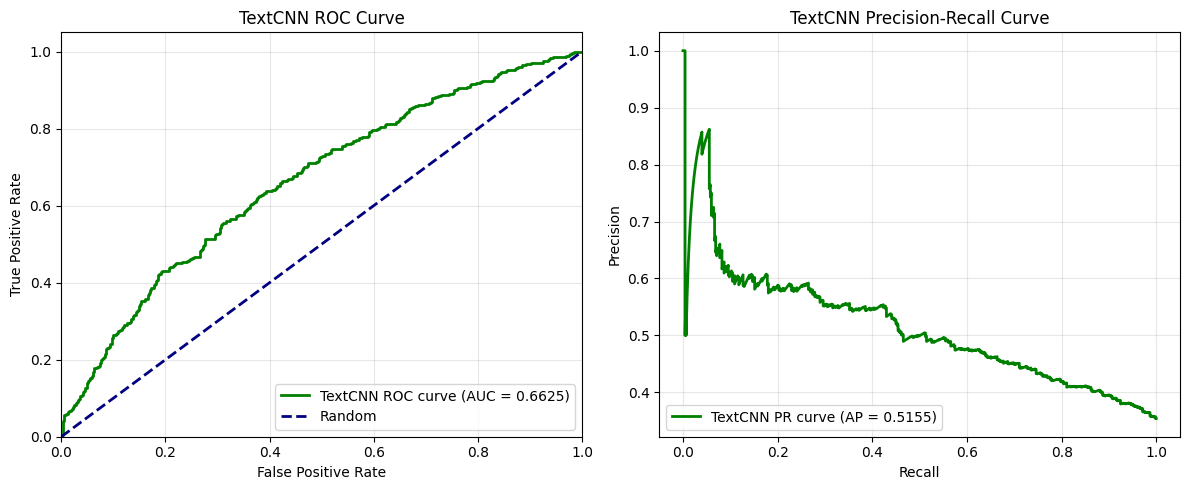

In [52]:
# Detailed performance analysis for TextCNN
print("=== DETAILED TextCNN PERFORMANCE ANALYSIS ===")

# Per-class performance
from sklearn.metrics import classification_report
print("\nTextCNN Classification Report:")
print(classification_report(textcnn_y_true_classes, textcnn_y_pred_classes, 
                          target_names=['False', 'True'], digits=4))

# ROC Curve
from sklearn.metrics import roc_curve, auc
textcnn_fpr, textcnn_tpr, textcnn_thresholds = roc_curve(textcnn_y_true_classes, textcnn_y_pred.flatten())
textcnn_roc_auc = auc(textcnn_fpr, textcnn_tpr)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(textcnn_fpr, textcnn_tpr, color='green', lw=2, label=f'TextCNN ROC curve (AUC = {textcnn_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TextCNN ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
textcnn_precision_vals, textcnn_recall_vals, _ = precision_recall_curve(textcnn_y_true_classes, textcnn_y_pred.flatten())
textcnn_avg_precision = average_precision_score(textcnn_y_true_classes, textcnn_y_pred.flatten())

plt.subplot(1, 2, 2)
plt.plot(textcnn_recall_vals, textcnn_precision_vals, color='green', lw=2, 
         label=f'TextCNN PR curve (AP = {textcnn_avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('TextCNN Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
# Analyze different prediction thresholds for TextCNN
textcnn_thresholds = np.arange(0.1, 1.0, 0.1)
textcnn_threshold_results = []

print("TextCNN Threshold Analysis:")
print("Threshold | Accuracy | Precision | Recall | F1-Score")
print("-" * 55)

for threshold in textcnn_thresholds:
    textcnn_pred_thresh = (textcnn_y_pred > threshold).astype(int).flatten()
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    acc = accuracy_score(textcnn_y_true_classes, textcnn_pred_thresh)
    prec = precision_score(textcnn_y_true_classes, textcnn_pred_thresh, zero_division=0)
    rec = recall_score(textcnn_y_true_classes, textcnn_pred_thresh, zero_division=0)
    f1 = f1_score(textcnn_y_true_classes, textcnn_pred_thresh, zero_division=0)
    
    textcnn_threshold_results.append([threshold, acc, prec, rec, f1])
    print(f"   {threshold:.1f}    |  {acc:.4f}  |  {prec:.4f}   |  {rec:.4f}  |  {f1:.4f}")

# Find best threshold based on F1 score
textcnn_threshold_results = np.array(textcnn_threshold_results)
textcnn_best_threshold_idx = np.argmax(textcnn_threshold_results[:, 4])  # F1 score column
textcnn_best_threshold = textcnn_threshold_results[textcnn_best_threshold_idx, 0]
textcnn_best_f1 = textcnn_threshold_results[textcnn_best_threshold_idx, 4]

print(f"\nTextCNN Best threshold: {textcnn_best_threshold:.1f} (F1-Score: {textcnn_best_f1:.4f})")

TextCNN Threshold Analysis:
Threshold | Accuracy | Precision | Recall | F1-Score
-------------------------------------------------------
   0.1    |  0.3567  |  0.3550   |  0.9978  |  0.5237
   0.2    |  0.3725  |  0.3596   |  0.9866  |  0.5271
   0.3    |  0.4136  |  0.3733   |  0.9644  |  0.5382
   0.4    |  0.5138  |  0.4095   |  0.8419  |  0.5510
   0.5    |  0.6393  |  0.4916   |  0.5234  |  0.5070
   0.6    |  0.6575  |  0.5949   |  0.1047  |  0.1780
   0.7    |  0.6456  |  0.0000   |  0.0000  |  0.0000
   0.8    |  0.6456  |  0.0000   |  0.0000  |  0.0000
   0.9    |  0.6456  |  0.0000   |  0.0000  |  0.0000

TextCNN Best threshold: 0.4 (F1-Score: 0.5510)


In [54]:
# Save the trained TextCNN model
print("Saving TextCNN model...")
textcnn_model.save('textcnn_model.keras')
print(f"TextCNN Model saved to: textcnn_model.keras")

# Save TextCNN training history
with open('textcnn_training_history.pkl', 'wb') as f:
    pickle.dump(textcnn_history.history, f)
print("TextCNN Training history saved to: textcnn_training_history.pkl")

# Save TextCNN predictions and results
textcnn_results_dict = {
    'test_metrics': textcnn_test_metrics,
    'y_pred': textcnn_y_pred,
    'y_pred_classes': textcnn_y_pred_classes,
    'y_true_classes': textcnn_y_true_classes,
    'confusion_matrix': textcnn_cm,
    'best_threshold': textcnn_best_threshold,
    'threshold_results': textcnn_threshold_results,
    'model_params': {
        'filter_sizes': [3, 4, 5],
        'num_filters': 128,
        'dense_units_1': 100,
        'dense_units_2': 50,
        'dropout_rate': 0.5,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'class_weights': CLASS_WEIGHT_DICT
    }
}

with open('textcnn_model_results.pkl', 'wb') as f:
    pickle.dump(textcnn_results_dict, f)
print("TextCNN Model results saved to: textcnn_model_results.pkl")

Saving TextCNN model...
TextCNN Model saved to: textcnn_model.keras
TextCNN Training history saved to: textcnn_training_history.pkl
TextCNN Model results saved to: textcnn_model_results.pkl


In [55]:
# Display final TextCNN summary
print("=" * 60)
print("             FINAL TextCNN MODEL SUMMARY")
print("=" * 60)

print(f"TextCNN Model Architecture:")
print(f"  - Embedding Layer: {MAX_WORDS} words, {EMBEDDING_DIM}D")
print(f"  - Conv1D Layers: {128} filters, sizes [3, 4, 5]")
print(f"  - Dense Layers: {100} -> {50} -> 1")
print(f"  - Dropout Rate: {0.5}")
print(f"  - Total Parameters: {textcnn_model.count_params():,}")

print(f"\nTextCNN Training Configuration:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Class Weights: {CLASS_WEIGHT_DICT}")

print(f"\nFinal TextCNN Test Performance:")
print(f"  - Accuracy: {textcnn_test_metrics['accuracy']:.4f}")
print(f"  - Precision: {textcnn_test_metrics['precision']:.4f}")
print(f"  - Recall: {textcnn_test_metrics['recall']:.4f}")
print(f"  - F1-Score: {textcnn_f1_score:.4f}")
print(f"  - AUC: {textcnn_test_metrics['auc']:.4f}")

print(f"\nOptimal Threshold: {textcnn_best_threshold:.1f}")

print(f"\nTextCNN Files Saved:")
print(f"  - Model: textcnn_model.keras")
print(f"  - Training History: textcnn_training_history.pkl")
print(f"  - Results: textcnn_model_results.pkl")
print(f"  - Preprocessed Data: preprocessed_data.pkl")

print("=" * 60)

             FINAL TextCNN MODEL SUMMARY
TextCNN Model Architecture:
  - Embedding Layer: 2000 words, 100D
  - Conv1D Layers: 128 filters, sizes [3, 4, 5]
  - Dense Layers: 100 -> 50 -> 1
  - Dropout Rate: 0.5
  - Total Parameters: 397,585

TextCNN Training Configuration:
  - Epochs: 10
  - Batch Size: 128
  - Class Weights: {0: 1.0, 1: 1.6}

Final TextCNN Test Performance:
  - Accuracy: 0.6393
  - Precision: 0.4916
  - Recall: 0.5234
  - F1-Score: 0.5070
  - AUC: 0.6627

Optimal Threshold: 0.4

TextCNN Files Saved:
  - Model: textcnn_model.keras
  - Training History: textcnn_training_history.pkl
  - Results: textcnn_model_results.pkl
  - Preprocessed Data: preprocessed_data.pkl


# Inference 

In [56]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import random

# Configuration parameters (matching the TextCNN notebook)
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 60
EMBEDDING_DIM = 100
MODEL_SAVE_PATH = "textcnn_model.keras"
BEST_THRESHOLD = 0.4  # From the TextCNN notebook's threshold analysis

def replace_labels(label):
    """Convert multi-class labels to binary classification (same as in notebook)"""
    label = label.lower().replace(" ", "-")
    return "true" if label in ["true", "mostly-true"] else "false"

# Load the test dataset
TEST_PATH = "test.tsv"
test_df = pd.read_csv(TEST_PATH, sep='\t', header=None)

# Load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

# Check if preprocessed test statements and tokenizer are available
test_statements_processed = preprocessed_data.get('test_statements_processed', None)
tokenizer = preprocessed_data.get('tokenizer', None)

if tokenizer is None:
    raise ValueError("Tokenizer not found in preprocessed_data.pkl")

# Select 10 random statements
random_indices = random.sample(range(len(test_df)), 10)
sample_df = test_df.iloc[random_indices]

# Use preprocessed statements if available, otherwise preprocess manually
if test_statements_processed is not None:
    sample_statements_processed = [test_statements_processed[i] for i in random_indices]
else:
    # Fallback to manual preprocessing (same as in TextCNN notebook)
    def preprocess_text(text):
        import nltk
        from nltk.corpus import stopwords
        from nltk.tokenize import word_tokenize
        from nltk.stem import WordNetLemmatizer
        import string
        tokens = word_tokenize(text)
        tokens = [word.lower() for word in tokens]
        tokens = [word for word in tokens if word not in string.punctuation]
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)

    def combine_text(df):
        df = df.fillna('')
        combined = (
            df[2].astype(str) + " " +  # statement
            df[3].astype(str) + " " +  # subject(s)
            df[4].astype(str) + " " +  # speaker
            df[5].astype(str) + " " +  # speaker's job title
            df[6].astype(str) + " " +  # state info
            df[7].astype(str) + " " +  # party affiliation
            df[13].astype(str)         # context (venue/location)
        )
        return combined.tolist()

    sample_statements = combine_text(sample_df)
    sample_statements_processed = [preprocess_text(statement) for statement in sample_statements]

# Convert to sequences and pad
sequences = tokenizer.texts_to_sequences(sample_statements_processed)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Load the saved TextCNN model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Make predictions
predictions = model.predict(padded_sequences, verbose=0)
predicted_classes = (predictions > BEST_THRESHOLD).astype(int).flatten()

# Map labels for true classes
true_labels = [replace_labels(label) for label in sample_df[1].tolist()]
true_classes = [1 if label == "true" else 0 for label in true_labels]

# Combine raw statements for display
sample_statements = combine_text(sample_df)

# Prepare data for DataFrame
results = {
    'Statement': [statement[:100] + "..." if len(statement) > 100 else statement for statement in sample_statements],
    'True Label': true_labels,
    'Predicted Probability': [f"{prob:.4f}" for prob in predictions.flatten()],
    'Predicted Class': ['true' if pred == 1 else 'false' for pred in predicted_classes],
    'Correct': [true_label == ('true' if pred == 1 else 'false') for true_label, pred in zip(true_labels, predicted_classes)]
}

# Create DataFrame
results_df = pd.DataFrame(results)

In [57]:
print("Inference Results for 10 Random Test Statements (TextCNN Model):")

Inference Results for 10 Random Test Statements (TextCNN Model):


In [58]:
results_df

,Statement,True Label,Predicted Probability,Predicted Class,Correct
0,Says the governor is going around the state ta...,false,0.5362,true,False
1,The Department of Homeland Security is the onl...,true,0.3983,false,False
2,"This town (Wilmington, Ohio) hasnt taken any m...",false,0.2858,false,True
3,Leticia Van de Putte opposed putting National ...,false,0.3250,false,True
4,John McCain fought to rein in Fannie and Fredd...,false,0.4469,true,False
5,The Obama administration gave Iran $400 millio...,false,0.1558,false,True
6,A bill by Earl Blumenauer would mandate GPS tr...,false,0.2383,false,True
7,Obamacare insurance cooperative failures shoul...,false,0.3552,false,True
8,The state is able to sharply curtail contract ...,true,0.4816,true,True
9,"Says that each year, about 25,000 American wom...",false,0.5431,true,False


In [59]:
# Calculate accuracy for these 10 samples
accuracy = sum(1 for t, p in zip(true_classes, predicted_classes) if t == p) / len(true_classes)
print(f"Accuracy for these 10 samples: {accuracy:.4f}")

Accuracy for these 10 samples: 0.6000
